In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super(VGG,self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,output_dim)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0],-1)
        x = self.classifier(h)
        return x, h # 리턴을 2개 한다!!!

In [3]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [4]:
def get_vgg_layers(config,batch_norm):
    layers = []
    in_channels = 3 # image의 처음은 c=3이니까(rbg)

    for c in config:
        assert c == 'M' or isinstance(c,int)
        if c == 'M':
            layers += [nn.MaxPool2d(2)]
        else:
            conv2d = nn.Conv2d(in_channels,c,3,1,1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c
    return nn.Sequential(*layers)

In [5]:
vgg11_layers = get_vgg_layers(vgg11_config,batch_norm=True)

In [6]:
OUTPUT_DIM = 2
PATH= '../data/model/VGG-model.pt'
model = VGG(vgg11_layers,OUTPUT_DIM)
model.load_state_dict(torch.load(PATH))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [7]:
from torchsummary import summary
model.to(device)
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
         MaxPool2d-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
      BatchNorm2d-10          [-1, 256, 64, 64]             512
             ReLU-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
      BatchNorm2d-13          [-1, 256, 64, 64]             512
             ReLU-14          [-1, 256,

In [8]:
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [9]:
train_path = '../data/cnd/train'
test_path = '../data/cnd/test'

train_dataset = torchvision.datasets.ImageFolder(train_path,transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=test_transforms)

print(len(train_dataset), len(test_dataset))

529 12


In [10]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * 0.9)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, [n_train_examples,n_valid_examples])

In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform= test_transforms

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of training examples: {len(valid_data)}')
print(f'Number of training examples: {len(test_dataset)}')

Number of training examples: 476
Number of training examples: 53
Number of training examples: 12


In [13]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset,batch_size=BATCH_SIZE)

In [14]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion= criterion.to(device)

In [15]:
def calculate_accuracy(y_pred,y): 
    top_pred = y_pred.argmax(1,keepdim=True) # top_pred.size() -> torch.Size([32, 1])
    corrects = top_pred.eq(y.view_as(top_pred)).sum() # 굳이 이렇게 어렵게 가야하나? y.view_as(top_pred).size() -> torch.Size([32, 1])
    acc = corrects.float() / y.shape[0]
    return acc

In [16]:
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)    # forward 함수에서 return을 2개 했다  x, h
        loss = criterion(y_pred, y)  # y_pred.size() -> torch.Size([32, 2]) # y.size() -> torch.Size([32])
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
import time

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
EPOCHS = 20
best_valid_loss = float('inf')
for epoch in range(EPOCHS):    
    start_time = time.monotonic()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../data/model/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.675 | Train Acc: 58.26%
	 Valid. Loss: 0.621 |  Valid. Acc: 73.58%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.660 | Train Acc: 59.99%
	 Valid. Loss: 0.620 |  Valid. Acc: 71.70%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 62.22%
	 Valid. Loss: 0.622 |  Valid. Acc: 73.58%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 61.89%
	 Valid. Loss: 0.623 |  Valid. Acc: 73.58%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.652 | Train Acc: 63.42%
	 Valid. Loss: 0.622 |  Valid. Acc: 73.58%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.661 | Train Acc: 62.14%
	 Valid. Loss: 0.620 |  Valid. Acc: 75.47%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.667 | Train Acc: 59.38%
	 Valid. Loss: 0.619 |  Valid. Acc: 73.58%
Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.663 | Train Acc: 63.23%
	 Valid. Loss: 0.619 |  Valid. Acc: 73.58%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.646 | Train Acc: 64.06%
	 Valid. Loss: 0.620 |  Valid. Acc:

In [21]:
model = model.to(device)
model.eval()
it = iter(test_iterator)
x,y = next(it)
with torch.no_grad():
    x = x.to(device)
    y = y.to(device)
    yp,_ =model(x)
    ypp = F.softmax(yp,dim=1)
    

In [22]:
pred_labels = torch.argmax(ypp,dim=1)

In [23]:
pred_labels.size()

torch.Size([12])

In [24]:
def get_predictions(model, iterator):
    model.eval()
    images=[]
    labels=[]
    probs=[]

    with torch.no_grad():
        for(x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred,_ = model(x)
            y_prob = F.softmax(y_pred,dim=1)
            top_pred = torch.argmax(y_prob,1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())  # [torch, torch, torch, ...]인 상태
    images = torch.cat(images,dim=0) # (len(iterator.dataset)만큼 합치기)!
    labels = torch.cat(labels,dim=0)
    probs = torch.cat(probs,0)
    return images, labels, probs


In [25]:
images, labels, probs = get_predictions(model,test_iterator)
pred_labels = torch.argmax(probs,dim=1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels,probs, corrects):
    if correct:
        correct_examples.append((image,label,prob))


In [27]:
# dim을 적용하면 torch.return_types.max(values=tensor(0.5143),indices=tensor(0))이 반환된다 -> .values을 적용한다
# 아니면 그냥 correct_examples.sort(reverse=True, key=lambda x : torch.max(x[2]))을 이용한다
correct_examples.sort(reverse=True, key=lambda x : torch.max(x[2],dim=0).values)

In [28]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min,max=image_max)
    image.add_(-image_min).div_(image_max-image_min +1e-5)
    return image

In [29]:
import matplotlib.pyplot as plt

In [30]:

def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25,20))
    for i in range(rows *cols):
        ax = fig.add_subplot(rows,cols,i+1)
        image, true_label,probs = correct[i]
        image = image.permute(1,2,0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs,dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)
        
        ax.imshow(image.numpy())
        ax.set_title('true label: {} ({:.3f})\n pred label: {} ({:.3f})'.format(true_class,true_prob,correct_class,correct_prob))
        ax.axis('off')
    fig.subplots_adjust(hspace=0.4)

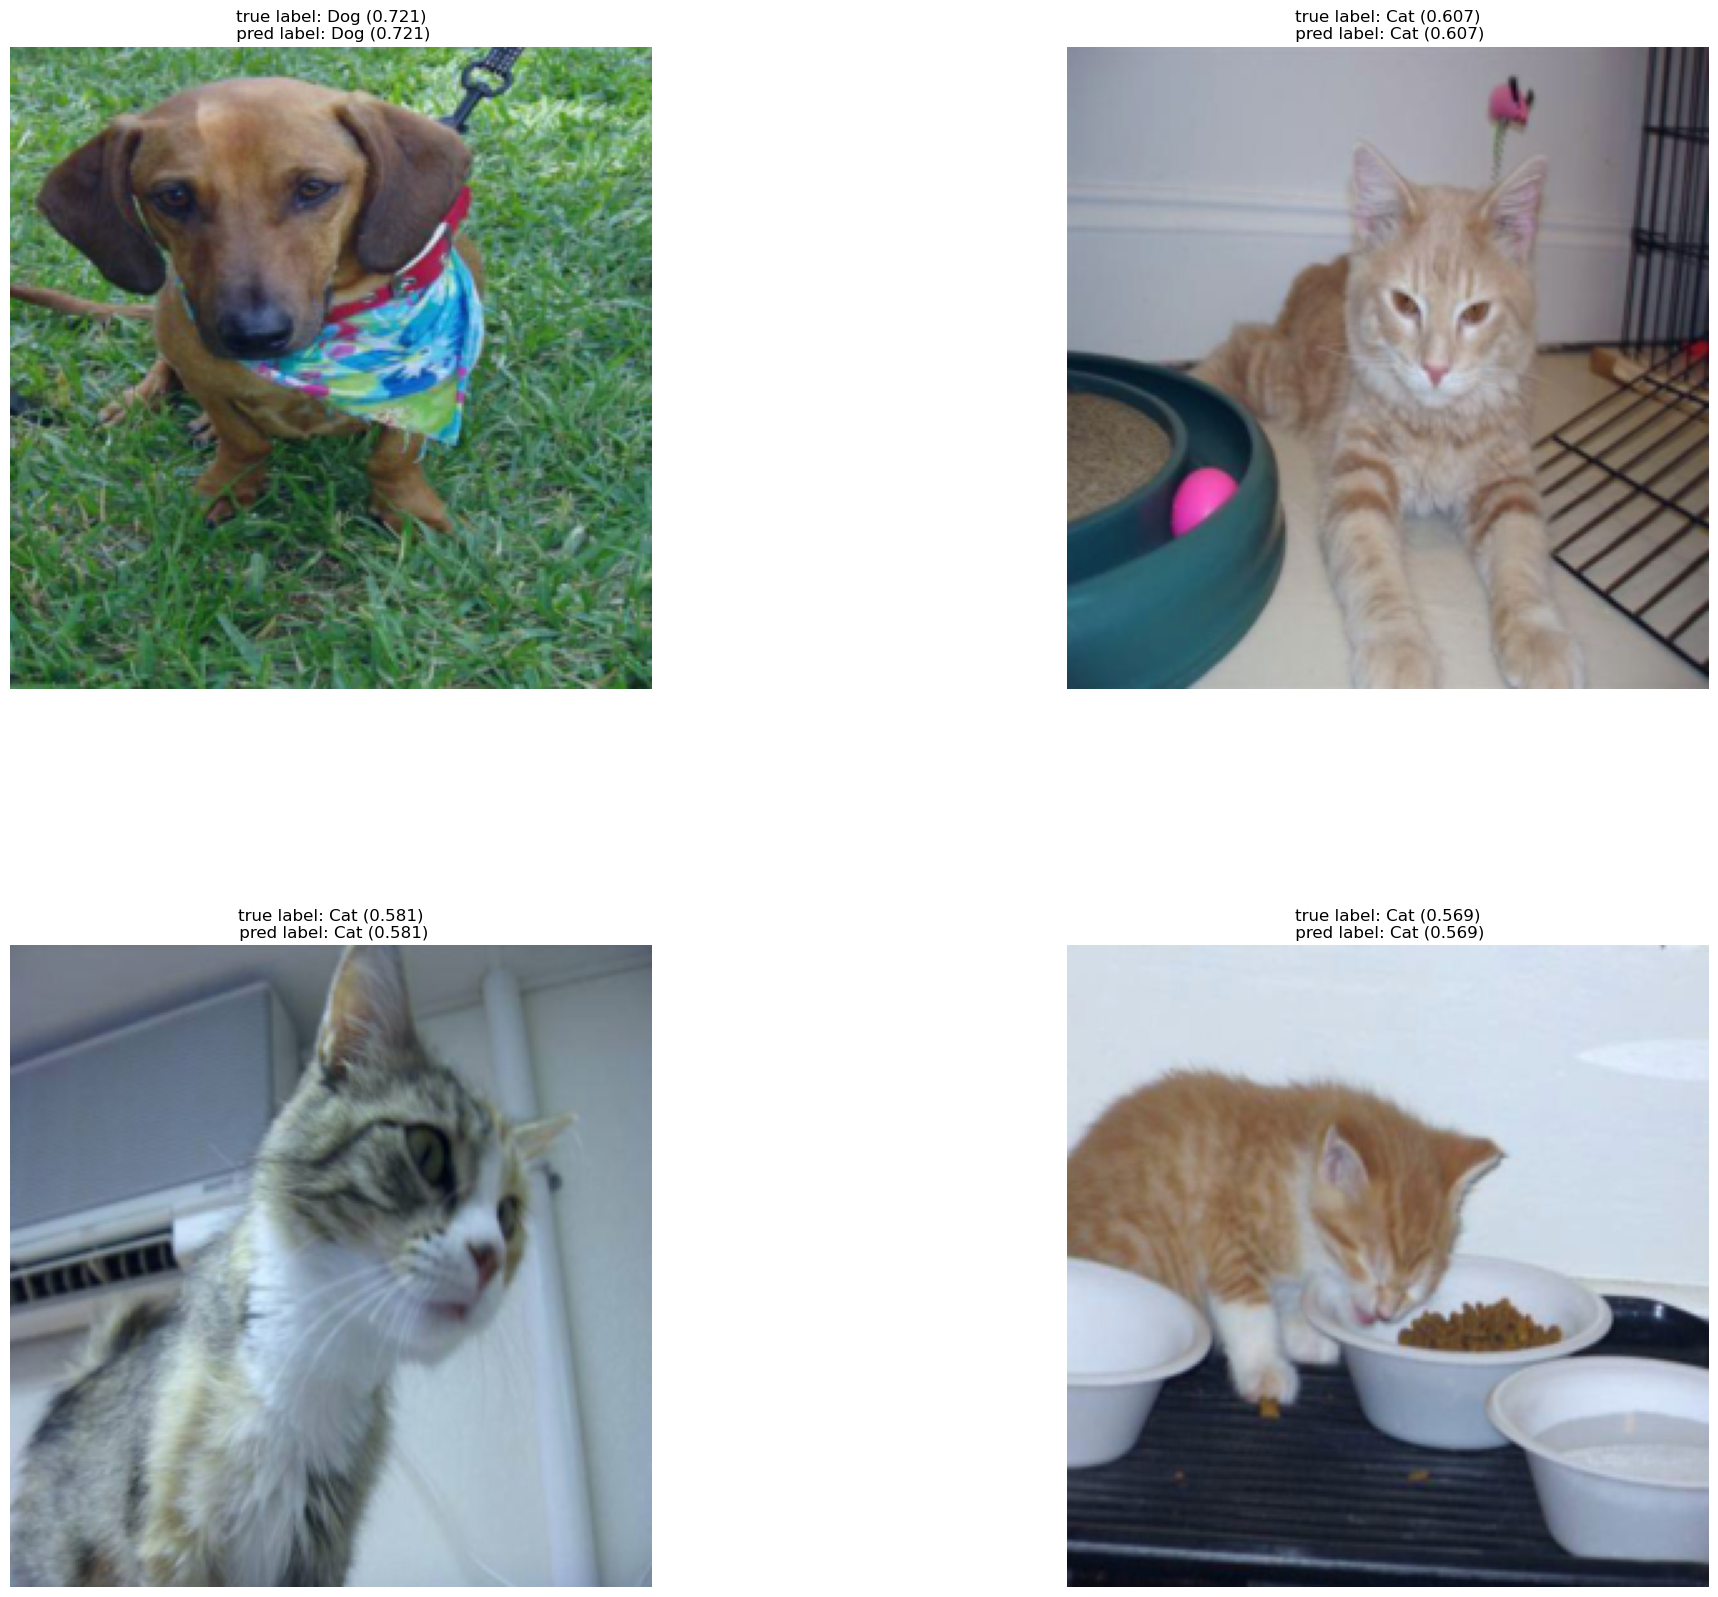

In [31]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples,classes,N_IMAGES)